In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from itertools import product
from scipy.stats import lognorm, norm
from sklearn.linear_model import LinearRegression 


DATA_DIR = Path('../data')
MODEL_DIR = Path('../models')

# Import Distribution Models

In [2]:
# Set up

with open(MODEL_DIR / 'siju_lognorm_fits.json', 'r') as infile:
    siju_lognorm_fits = json.load(infile)
    
with open(MODEL_DIR / 'hije_norm_fits.json', 'r') as infile:
    hije_norm_fits = json.load(infile)
    
lobes = ["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5']
stimuli = ['citronella', 'ethanol', 'heptanone', 'hexanol', 'mch', 'octanol',
       'peppermint', 'vinegar', 'yeast']

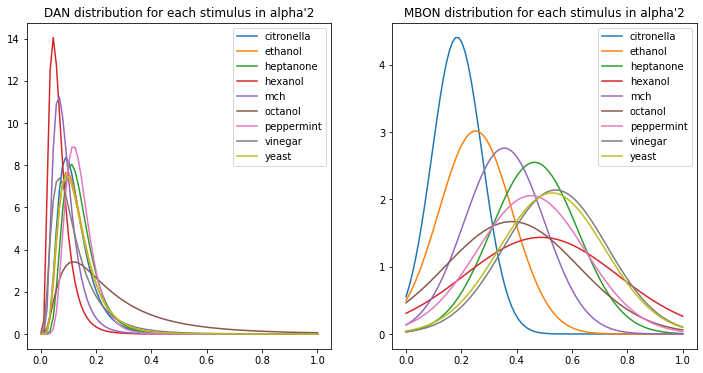

In [3]:
# Visualise

lobe = lobes[1]
x = np.linspace(0,1,90)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].set_title(f'DAN distribution for each stimulus in {lobe}')
axes[1].set_title(f'MBON distribution for each stimulus in {lobe}')

for stimulus in stimuli:
    
    siju_params = siju_lognorm_fits[lobe][stimulus]
    siju_rv = lognorm(s=siju_params[0], loc=siju_params[1], scale=siju_params[2])
    y = siju_rv.pdf(x)
    axes[0].plot(x, y, label=stimulus)
        
    hije_params = hije_norm_fits[lobe][stimulus]
    hije_rv = norm(loc=hije_params[0], scale=hije_params[1])
    y = hije_rv.pdf(x)
    axes[1].plot(x, y, label=stimulus)

axes[0].legend()
axes[1].legend()

plt.show()

# Build data matrix from distributions

In [6]:
samples_per_stimulus = 1000

X = np.zeros([len(stimuli) * samples_per_stimulus, len(lobes)])
Y = np.zeros([len(stimuli) * samples_per_stimulus, len(lobes)])

for i, stimulus in enumerate(stimuli):
    for j, lobe in enumerate(lobes):
        mbon_params = hije_norm_fits[lobe][stimulus]
        dan_params = siju_lognorm_fits[lobe][stimulus]
        
        mbon_rv = norm(loc=mbon_params[0], scale=mbon_params[1])
        dan_rv = lognorm(s=dan_params[0], loc=dan_params[1], scale=dan_params[2])
        
        X[i*samples_per_stimulus:(i+1)*samples_per_stimulus, j] = dan_rv.rvs(samples_per_stimulus)
        Y[i*samples_per_stimulus:(i+1)*samples_per_stimulus, j] = mbon_rv.rvs(samples_per_stimulus)  

print(f'Num trials: {samples_per_stimulus}x{len(stimuli)} = {X.shape[0]}')
print(f'Input shape: {X.shape}')
print(f'Output shape: {Y.shape}')

Num trials: 1000x9 = 9000
Input shape: (9000, 15)
Output shape: (9000, 15)


# Create Time Series for Each Trial

Data should end up in the shape (num_lobes, time_steps, trials)

In [6]:
# Convert the DAN activity (inputs) into time series
X_e = X.T
X_e = np.expand_dims(X_e, axis=1)
Z = np.zeros_like(X_e)
X_ts = np.concatenate((Z, X_e, Z), axis=1)

print(X_ts.shape)

(15, 3, 9000)


In [7]:
# Convert the MBON activity (outputs) into time series

Y_e = np.expand_dims(Y.T, axis=1)
Z = np.zeros_like(Y_e)
Y_ts = np.concatenate((Z, Y_e, Z), axis=1)

print(Y_ts.shape)

(15, 3, 9000)


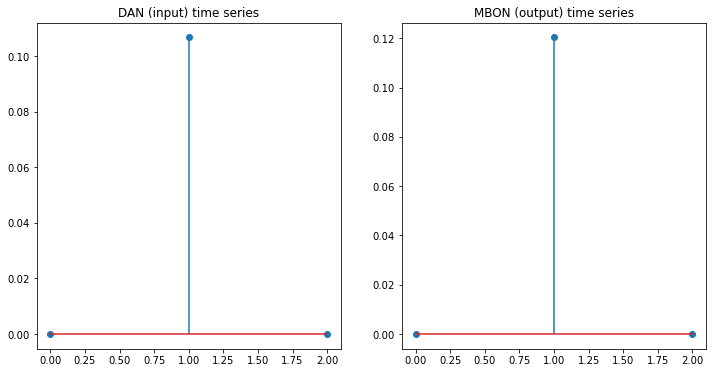

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].set_title(f'DAN (input) time series')
axes[1].set_title(f'MBON (output) time series')

axes[0].stem(X_ts[0, :, 0])
axes[1].stem(Y_ts[0, :, 0])

plt.show()

In [9]:
np.save(DATA_DIR / 'X-time-series-from-distribution.npy', X_ts, allow_pickle=True)
np.save(DATA_DIR / 'Y-time-series-from-distribution.npy', Y_ts, allow_pickle=True)